# Readabilty and semantic cohesion between MOOCs sections - Part III


## Introduction

We explore whether we can infer vector representations for course sections and capture semantics similarities between them using doc2vec model.  This might be useful to identify how smooth is the content flow of the course.  

### Importing libriaries and gensim model

In [68]:
import gensim
from gensim.models import Doc2Vec

model0 = Doc2Vec.load("model0") # loading trained doc2vec model
print (len(model0.docvecs))

285


### Defining text preprocessing function

The data was preprocessed so that all the punctuation,  numerical symbols and stop words were removed from the text.

In [69]:
import os,re,json
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize,wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

def text_preprocess(raw, code):
    
    hiragana_full = r'[ぁ-ゟ]'
    katakana_full = r'[゠-ヿ]'
    kanji = r'[㐀-䶵一-鿋豈-頻]'
    
    list_of_words = []
    raw = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)",'', raw)
    raw = re.sub("&#39;", "'", raw)
    
    #remove japanese chars
    raw = re.sub(hiragana_full,'', raw)
    raw = re.sub(katakana_full,'', raw)
    raw = re.sub(kanji,'', raw)
    
    token = wordpunct_tokenize(raw)
    stopword_obj = stopwords.words('english')
    list_of_words=[]
    steming_type = PorterStemmer()
    for i in token:
        processed_tmp = i.lower()
        
        if len(processed_tmp) == 1:
            continue
        
        if code[0] == '1':
            if not processed_tmp.isalpha():
                continue
        else:
            if not processed_tmp.isalnum():
                continue

        if code[1] == '1':
            if processed_tmp in stopword_obj:
                continue
     
        if code[2] == '1':
            processed_tmp = steming_type.stem(processed_tmp)
        
        list_of_words.append(processed_tmp)

    return list_of_words

Using similar document embedding approach as before, we now learn vectors for individual MOOC sections.  
Since section consists of multiple components, we combined the data from all the components.

In [70]:
from os import listdir
import json
from os.path import isfile, join

# extract and store the content of the sections in a dictionary 
def get_course_sections(course_path):
    
    section_to_content =  defaultdict(list)
    sections = next(os.walk(course_path))[1]
    
    for comp_type in selected_components:
        if os.path.exists(os.path.join(course_path,comp_type)):
            with open(os.path.join(course_path,comp_type),'r',encoding='utf-8') as file:
                json_data = json.loads(file.read())      
                for sec in sections:
                    for main_key, main_value in json_data.items():
                        if (main_value['section']==sec):
                            if comp_type == 'all_videocomp.json' and main_value['transcript_en']!='': 
                                section_to_content[sec].append(main_value['transcript_en'])
                            if comp_type == 'all_textcomp.json' and main_value['content']!='': 
                                section_to_content[sec].append(main_value['content'])  
        else:
            continue
    return section_to_content

Our hypothesis is that if the model learns vector representations of the individual sections well, then we should be able to see higher similarity scores between two neighboring section vectors, rather than between two sections far apart in the course.

To  verify  this  hypothesis,  we  define  two  measures:
* Pairwise comparison score
* Linear comparison score

The  first  measure, pairwise comparison score measures how similar are any two sections in the course. Pairwisecomparison score (pc-score)compares each section to every other section in the given MOOC,
resulting in (N choose 2)comparison pairs.

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_parwise_similarity(section_to_vector):
        
    total_sum = 0
    keys = sorted(section_to_vector.keys())
    
    for i in range(0, len(keys)): 
        for j in range(i+1, len(keys)):
            vector_i = section_to_vector[keys[i]].reshape(1, -1)
            vector_j = section_to_vector[keys[j]].reshape(1, -1)
            cos_sim = cosine_similarity(vector_i, vector_j)
            total_sum += cos_sim
    if(len(section_to_vector)>1):        
        total_section_sim = total_sum*2/((len(section_to_vector))**2)
    else:
        total_section_sim = total_sum
        
    print ("Pairwise_similarity: {0} ".format(total_section_sim))
    
    return total_section_sim

The second measure we defined is section’s linear similarity score. Linear comparison score (lc-sore) compares sections sequentially:  first section to the second, second to the third, and so on. If themodel is trained well, it should capture the semantic similarity of consequent sections, and linear similarity should be higher than pairwise similarity.

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_linear_similarity(section_to_vector):
    
    cur_ind = 0
    total_sum_linear=0
    keys = sorted(section_to_vector.keys())
    linear_similarities = []
    
    for next_ind in range(1,len(keys)):
        vector_i = section_to_vector[keys[cur_ind]].reshape(1, -1)
        vector_j = section_to_vector[keys[next_ind]].reshape(1, -1)
        cos_sim = cosine_similarity(vector_i,vector_j)
        linear_similarities.append(cos_sim)
        total_sum_linear += cos_sim
        cur_ind += 1
        
    if(len(section_to_vector)>1):        
        total_section_sim_linear = total_sum_linear/(len(section_to_vector)-1)
    else:
        total_section_sim_linear = total_sum_linear
        
    print ("Linear_similarity: {0} ".format(total_section_sim_linear))
    
    return total_sum_linear/(len(keys)-1), linear_similarities

## Compute section vectors for the entire dataset

Next, we calculate  lc-score and pc-score for all the courses in our dataset. We identified the overall trend that lc-scores are higher than pc-scores for majority of the MOOCs.

In [73]:
from collections import defaultdict

rootDir='/home/zarina/Documents/OEDO/web-crawler/HTMLs/'
selected_components=['all_textcomp.json', 'all_videocomp.json']
course_dir = [tmp for tmp in os.listdir(rootDir)]
readabilities=[]
case_count=0

pairwise_sim_points = []
linear_sim_points = []
course_names = []

for course in course_dir:
    
    course_names.append(course)
    course_path=rootDir+course #/rootDir/course_name
    print (course_path)
    
    section_to_content =  defaultdict(list)
    section_to_vector =  defaultdict(list)
    
    section_to_content = get_course_sections(course_path)
    
    section_to_vector =  defaultdict(list)
    for key, value in section_to_content.items():
        #combine list
        section_txt=''.join(str(e) for e in value)
        #clean text '110' - alphabetic, numeric
        clean_txt=text_preprocess(section_txt, '110')
        #inferred_embedding
        inferred_embedding = model0.infer_vector(clean_txt)
        #store embedding in map
        section_to_vector[key]=inferred_embedding
    
    pairwise_section_sim = compute_parwise_similarity(section_to_vector)
    pairwise_sim_points.append(pairwise_section_sim)
    
    linear_section_sim, _ = compute_linear_similarity(section_to_vector)
    linear_sim_points.append(linear_section_sim)
    
    if (linear_section_sim < pairwise_section_sim):
        print ("UNUSUAL CASE")
        case_count+=1
    
    #course_readability = compute_average_readability(section_to_content)
    #readabilities.append(course_readability)
    
print ("UNUSUAL CASE COUNT", case_count)


/home/zarina/Documents/OEDO/web-crawler/HTMLs/Global_Social_Change
Pairwise_similarity: [[0.4598183]] 
Linear_similarity: [[0.5645105]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Compliance_in_Office_365-_Data_Governance
Pairwise_similarity: [[0.36815226]] 
Linear_similarity: [[0.47528377]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/DNA_Sequences-_Alignments_and_Analysis
Pairwise_similarity: [[0.4475976]] 
Linear_similarity: [[0.53283197]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Cyberwar_Surveillance_and_Security
Pairwise_similarity: [[0.5030408]] 
Linear_similarity: [[0.6166206]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Luxury_Management
Pairwise_similarity: [[0.3712026]] 
Linear_similarity: [[0.39380205]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Solar_Energy-_Photovoltaic_PV_Systems
Pairwise_similarity: [[0.4258001]] 
Linear_similarity: [[0.60358715]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Supply_Chain_Management-_A_Decision-Making_Framework
Pairwis

Pairwise_similarity: [[0.4680661]] 
Linear_similarity: [[0.51634926]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Information_Systems_and_Computer_Applications_Part_5-_Social_Implications
Pairwise_similarity: [[0.3760592]] 
Linear_similarity: [[0.5626652]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Ignorance
Pairwise_similarity: [[0.58533275]] 
Linear_similarity: [[0.69740665]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Introduction_to_Corporate_Finance
Pairwise_similarity: [[0.34997976]] 
Linear_similarity: [[0.50919604]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Innovation_Generation-_How_to_Be_Creative
Pairwise_similarity: [[0.47024345]] 
Linear_similarity: [[0.583652]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/The_Search_for_Vernacular_Architecture_of_Asia_Part_1
Pairwise_similarity: [[0.43382293]] 
Linear_similarity: [[0.59372026]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Foreign_Exchange_Markets-_Instruments_Risks_and_Derivatives
Pairwise_similarity: [[

Pairwise_similarity: [[0.4346245]] 
Linear_similarity: [[0.6198057]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Computation_Structures_3-_Computer_Organization
Pairwise_similarity: [[0.32115448]] 
Linear_similarity: [[0.41584954]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Digital_Networks_Essentials
Pairwise_similarity: [[0.45015174]] 
Linear_similarity: [[0.5464226]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Leadership_for_Engineers
Pairwise_similarity: [[0.42475402]] 
Linear_similarity: [[0.5612949]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/ChinaX_Part_1-_Political_and_Intellectual_Foundations-_From_the_Sage_Kings_to_Confucius_and_the_Legalists
Pairwise_similarity: [[0.37487003]] 
Linear_similarity: [[0.4498566]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Fundamentals_of_Manufacturing_Processes
Pairwise_similarity: [[0.4954486]] 
Linear_similarity: [[0.5622459]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Counseling_and_Psychotherapy_Theory
Pairwise_similar

Pairwise_similarity: [[0.41385862]] 
Linear_similarity: [[0.4815242]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Applied_Machine_Learning
Pairwise_similarity: [[0.27926025]] 
Linear_similarity: [[0.41846523]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Mechanics-_Momentum_and_Energy
Pairwise_similarity: [[0.4041219]] 
Linear_similarity: [[0.5367621]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Discrete_Time_Signals_and_Systems_Part_2-_Frequency_Domain
Pairwise_similarity: [[0.42145512]] 
Linear_similarity: [[0.5904765]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Introduction_to_Human_Evolution
Pairwise_similarity: [[0.48095015]] 
Linear_similarity: [[0.56427276]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Evaluating_Designs_with_Users
Pairwise_similarity: [[0.38718376]] 
Linear_similarity: [[0.550151]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Microsoft_SharePoint_2016-_Workload_Optimization
Pairwise_similarity: [[0.3547286]] 
Linear_similarity: [[0.4793863]] 
/h

Pairwise_similarity: [[0.43683022]] 
Linear_similarity: [[0.5303006]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Journalism_for_Social_Change
Pairwise_similarity: [[0.4822164]] 
Linear_similarity: [[0.6108233]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Becoming_a_Resilient_Person-_The_Science_of_Stress_Management_and_Promoting_Wellbeing
Pairwise_similarity: [[0.5729397]] 
Linear_similarity: [[0.6527472]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Introduction_to_Animal_Ethics
Pairwise_similarity: [[0.42177954]] 
Linear_similarity: [[0.58629805]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Underactuated_Robotics
Pairwise_similarity: [[0.39453566]] 
Linear_similarity: [[0.44940645]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/u.lab-_Leading_From_the_Emerging_Future
Pairwise_similarity: [[0.4631704]] 
Linear_similarity: [[0.47400415]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Causal_Diagrams-_Draw_Your_Assumptions_Before_Your_Conclusions
Pairwise_similarity: [[0.41

Pairwise_similarity: [[0.34515116]] 
Linear_similarity: [[0.486961]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Quantum_Mechanics-_Wavefunctions_operators_and_expectation_values
Pairwise_similarity: [[0.3973407]] 
Linear_similarity: [[0.576503]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Digital_Strategy_and_Action
Pairwise_similarity: [[0.41966546]] 
Linear_similarity: [[0.5668876]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/DO_Your_Venture_-_Entrepreneurship_for_Everyone
Pairwise_similarity: [[0.4558932]] 
Linear_similarity: [[0.54482687]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Statistics_and_Probability_in_Data_Science_using_Python
Pairwise_similarity: [[0.42229533]] 
Linear_similarity: [[0.58309907]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Developing_Windows_10_Universal_Apps__Part_2
Pairwise_similarity: [[0.39211106]] 
Linear_similarity: [[0.5485779]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/An_Introduction_to_Evidence-Based_Undergraduate_STEM_Teac

Pairwise_similarity: [[0.49498194]] 
Linear_similarity: [[0.60551244]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Robot_Mechanics_and_Control_Part_I
Pairwise_similarity: [[0.37196568]] 
Linear_similarity: [[0.529012]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Leadership_and_Management_for_PM_Practitioners_in_IT
Pairwise_similarity: [[0.5357923]] 
Linear_similarity: [[0.7511633]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Principles_of_Economics_with_Calculus
Pairwise_similarity: [[0.55435836]] 
Linear_similarity: [[0.6912678]] 
/home/zarina/Documents/OEDO/web-crawler/HTMLs/Financial_Decision_Making
Pairwise_similarity: [[0.43991387]] 
Linear_similarity: [[0.5542982]] 
UNUSUAL CASE COUNT 3


In figure bellow you can see, that mean value of lc-score distribution is higher than the mean of pc-score distribution.

/home/zarina/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


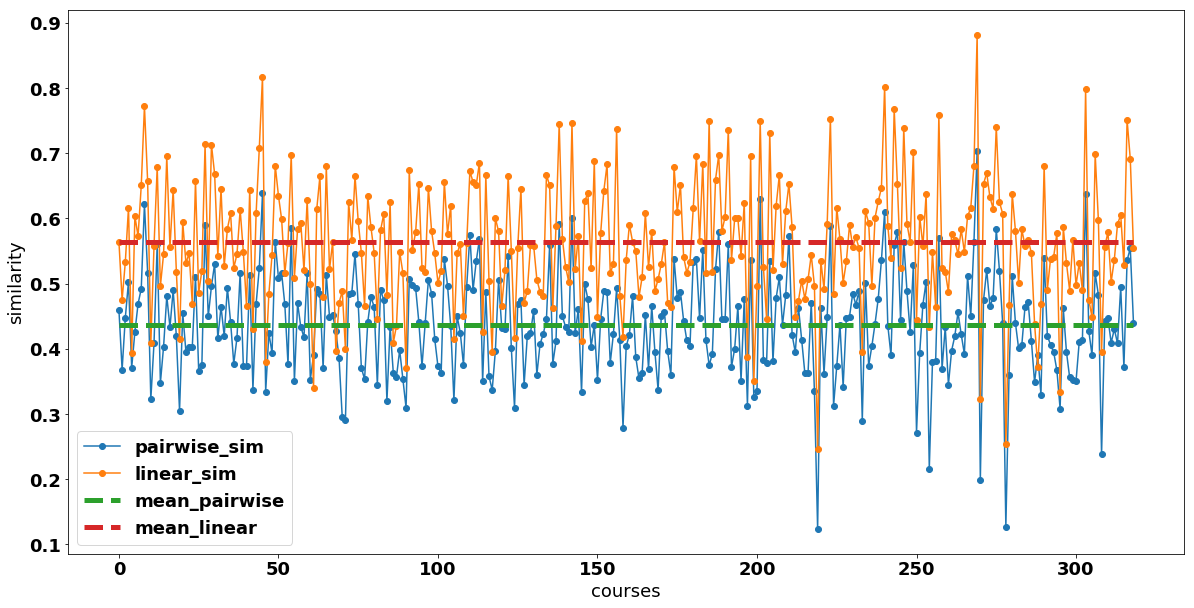

In [74]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

mean_pairwise = [np.mean(pairwise_sim_points)]*len(pairwise_sim_points)
mean_linear = [np.mean(linear_sim_points)]*len(linear_sim_points)

plt.figure(figsize=(20,10))
plt.plot(np.array(range(len(pairwise_sim_points))), np.array(pairwise_sim_points).reshape(-1,1), 'o-')
plt.plot(np.array(range(len(linear_sim_points))), np.array(linear_sim_points).reshape(-1,1), 'o-')

# Plot the average line
plt.plot(np.array(range(len(pairwise_sim_points))),mean_pairwise, label='Mean', linestyle='--', linewidth=5.0)
plt.plot(np.array(range(len(linear_sim_points))),mean_linear, label='Mean', linestyle='--', linewidth=5.0)

plt.xlabel('courses')
plt.ylabel('similarity')

plt.legend(['pairwise_sim', 'linear_sim', 'mean_pairwise', 'mean_linear'], loc='lower left')
plt.show()

#  Section similarities of TitechX courses

In [38]:
from textstat.textstat import textstat

# compute readability for course sections
def compute_readability(section_to_content):
    
    section_readabilities = []
    keys = sorted(section_to_content.keys())
    
    for section in range(0,len(keys)):
        list_txt = section_to_content[keys[section]]
        txt = ''.join(str(e) for e in list_txt)
        readability = textstat.flesch_reading_ease(txt)
        section_readabilities.append(readability)
    
    return section_readabilities 

/home/zarina/Documents/OEDO/web-crawler/HTMLs_titech/Modern_Japanese_Architect-Meiji_Restoration_to_Today
Pairwise_similarity: [[0.37544176]] 
Sections readabilities [60.04, 42.45, 34.8, 33.17, 33.07, 31.45, 48.43, 29.86]
Linear_similarity: [[0.4984351]] 


/home/zarina/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


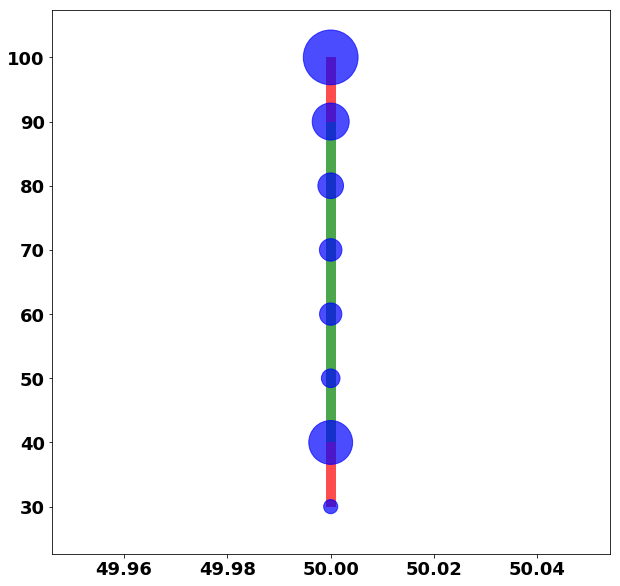

/home/zarina/Documents/OEDO/web-crawler/HTMLs_titech/Introduction_to_Deep_Earth_Science
Pairwise_similarity: [[0.4159412]] 
Sections readabilities [64.71, 65.12, 53.81, 54.42, 45.56, 53.41, 62.27, 65.01]
Linear_similarity: [[0.5237802]] 


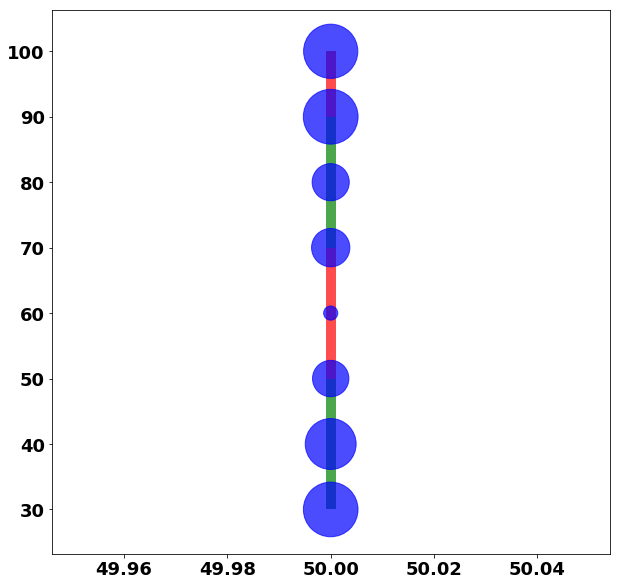

/home/zarina/Documents/OEDO/web-crawler/HTMLs_titech/Introduction_to_Electrical_and_Electronic_Engineering_-__Self-Paced
Pairwise_similarity: [[0.31473765]] 
Sections readabilities [47.89, 65.32, 49.21, 46.81, 58.28, 58.82]
Linear_similarity: [[0.4682917]] 


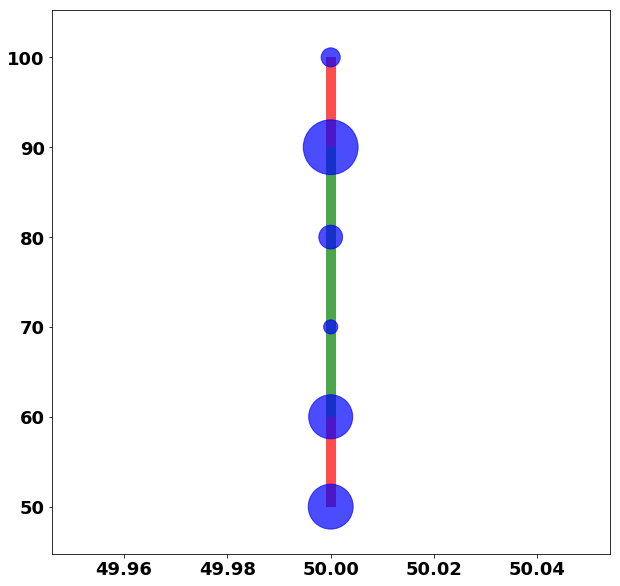

/home/zarina/Documents/OEDO/web-crawler/HTMLs_titech/Autophagy-_Research_Behind_the_2016_Nobel_Prize_in_Physiology_or_Medicine
Pairwise_similarity: [[0.42325264]] 
Sections readabilities [52.6, 54.63, 52.39, 51.99]
Linear_similarity: [[0.55728495]] 


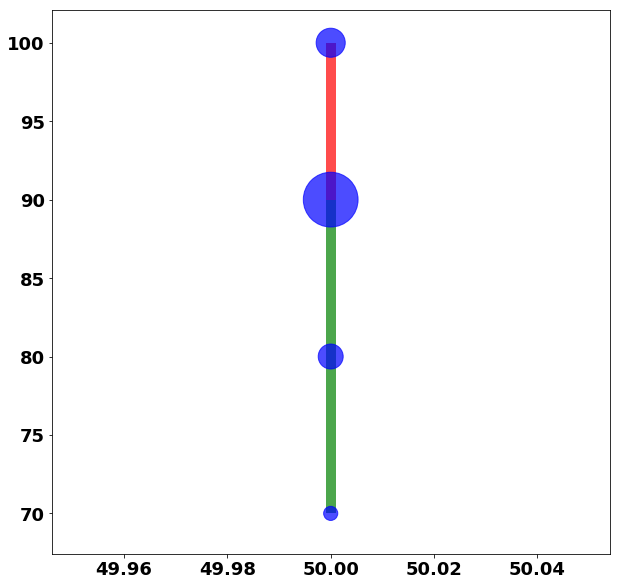

In [78]:
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
#from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np

rootDir='/home/zarina/Documents/OEDO/web-crawler/HTMLs_titech/'
selected_components=['all_textcomp.json', 'all_videocomp.json']
course_dir = [tmp for tmp in os.listdir(rootDir)]
readabilities=[]
case_count=0

pairwise_sim_points = []
linear_sim_points = []
course_names = []

for course in course_dir:
    
    course_names.append(course)
    course_path = rootDir + course #/rootDir/course_name
    print (course_path)
    
    section_to_content =  defaultdict(list)
    section_to_vector =  defaultdict(list)
    
    section_to_content = get_course_sections(course_path)
    
    section_to_vector =  defaultdict(list)
    for key, value in section_to_content.items():
        #combine list
        section_txt=''.join(str(e) for e in value)
        #clean text '110' - alphabetic, numeric
        clean_txt=text_preprocess(section_txt, '110')
        #inferred_embedding
        inferred_embedding = model0.infer_vector(clean_txt)
        #store embedding in map
        section_to_vector[key]=inferred_embedding
    
    pairwise_section_sim = compute_parwise_similarity(section_to_vector)
    pairwise_sim_points.append(pairwise_section_sim)
    
    G=nx.Graph()
    node_sizes=[]
        
    section_readabilities = compute_readability(section_to_content)
    print ("Sections readabilities", section_readabilities)
    node_sizes = section_readabilities
    
    section_names = list(section_to_content.keys())
    for i, name in enumerate(section_names):
        G.add_node(name ,pos=(50, 100-i*10))

    #normailzing readability to draw node sizes
    scaler = MinMaxScaler(feature_range=(200, 3000))
    scaler = scaler.fit( np.array(node_sizes).reshape(-1, 1))
    normalized = scaler.transform(np.array(node_sizes).reshape(-1, 1))
    
    plt.figure(figsize=(10,10))
    pos=nx.get_node_attributes(G,'pos')
    nx.draw_networkx_nodes(G, pos,  node_size=normalized, node_color='b', alpha=0.7)
    
    #defining edge weights as ls-score
    _, linear_similarities = compute_linear_similarity(section_to_vector)
   
    for ind in range(len(section_names) - 1):#iterate thru sections
        G.add_edge(section_names[ind], section_names[ind+1], weight=linear_similarities[ind])
    
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]
     
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=10, alpha=0.7, edge_color='g',length=10000)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=10, alpha=0.7, edge_color='r', length=10000)
    
    plt.show()
